In [225]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns

random.seed(1220)

This script will generate example decision-making data on a very simple college admissions process, consisting of three groups with equivalent distributions in innate TestingAbility to graduate college. However, some groups have a higher likelihood of receiving application assistance in the form of test prep. Each applicant gets an entrance test score, which we assume to be a function of their individual graduation likelihood plus some constant boost if they've recieved test prep. Thus, admissions teams using test scores to predict a student's likelihood of graduation are somewhat misled by this test prep effect.

In [226]:
sim_params =  {
    'POP_SIZE' : 50000,
    'POP_RATIO' : [1/5, 1/5],
    'GROUPS' : ['A', 'B'],
    'HSI_VALUE_ADDED_MEAN' : {1 : 15, 
                            0 : 0},
    'HSI_VALUE_ADDED_SD' : {1 : 5, 
                            0 : 5},                        
    'GROUP_HSI' : {'A': .8, 
                'B': .2},
    'GROUP_COLLEGE_FUND_ALPHA': {'A' : 4,
                                'B' : 2},   
    'GROUP_COLLEGE_FUND_BETA': {'A' : 1,
                                'B' : .8},                 
    'TRUE_RATING_MEAN' : 100,
    'TRUE_RATING_SD' : 10,
    'TESTING_ABILITY_SD' : 10,
}

MODEL_PREDICTORS =  ['TestScore', 'HighSchool_Indigo', 'CollegeFund']


def sim_graduation(admissions_data):
    admissions_data.loc[:,'Actual_Graduation'] = \
        admissions_data.loc[:,'p_Graduation'].apply(
            lambda x: random.choices([1,0], cum_weights=[x, 1])[0])
    return admissions_data

# Modify ACTUAL predictors in this function - this determines what actually predicts graduation
def calc_grad_prob(sim_admission, noise = 3, offset = 110):
    import math
    sim_admission.loc[:,'p_Graduation'] = sim_admission.apply(
        lambda row: 1/(1+ math.e**(-.2*(
            (row['BaseAbility'] + row['HSValueAdded'] + row['CollegeFund']) - offset + \
            # (row['BaseAbility'] + row['HSValueAdded'] + math.log1p(row['CollegeFund'])) - offset + \
            int(random.gauss(0, noise))))), axis=1)
    return sim_admission

def sim_admissions_data(POP_SIZE, POP_RATIO, GROUPS, HSI_VALUE_ADDED_MEAN, HSI_VALUE_ADDED_SD,
                        GROUP_HSI, GROUP_COLLEGE_FUND_ALPHA, GROUP_COLLEGE_FUND_BETA, 
                        TRUE_RATING_MEAN, TRUE_RATING_SD, TESTING_ABILITY_SD):
# simulate population consisting of given size and distribution, with a 'true' rating for each student,
# as well as factors that correlate strongly with their true rating
    sim_admission = pd.DataFrame(
        {'Group' : random.choices(GROUPS, weights=POP_RATIO, k = POP_SIZE),
        'BaseAbility': [int(random.gauss(
            TRUE_RATING_MEAN, TRUE_RATING_SD)) for _ in range(POP_SIZE)]})

    ##NOTE this would be more realistic if we call HSValueAdded something harder to observe that 
    ##is disproportionate across groups

    # assign each individual to a high school depending on their likelihood of going to High School Indigo
    sim_admission.loc[:, 'HighSchool_Indigo'] = sim_admission.loc[:, 'Group']\
        .apply(lambda grp: random.choices([1,0], cum_weights=[GROUP_HSI[grp], 1])[0])
    
    # assign a college fund according to the beta distribution
    sim_admission.loc[:, 'CollegeFund'] = sim_admission.loc[:, 'Group']\
        .apply(lambda grp: float(max(random.gammavariate(alpha= GROUP_COLLEGE_FUND_ALPHA[grp],
                                                       beta = GROUP_COLLEGE_FUND_BETA[grp]), 0)))

    # assign each individual a 'value added' from their school's quality
    # (this is assumed to be normally distributed as per fixed effects modelling value added literature)
    sim_admission.loc[:, 'HSValueAdded'] = sim_admission.loc[:, 'HighSchool_Indigo']\
        .apply(lambda hsi: int(random.gauss(HSI_VALUE_ADDED_MEAN[hsi], HSI_VALUE_ADDED_SD[hsi])))

    # assign each individual a 'test ability' (this will encompass the error term in
    # our later regression and is unobserved)
    sim_admission.loc[:, 'TestingAbility'] = [int(random.gauss(0, TESTING_ABILITY_SD)) for _ in range(POP_SIZE)]

    # assign a test score as a function of their actual grad chance, any test prep, and some noise
    sim_admission.loc[:, 'TestScore'] = \
        (sim_admission.loc[:, 'BaseAbility'] + 
        sim_admission.loc[:, 'HSValueAdded'] / 2 +
        # sim_admission.loc[:, 'CollegeFund'].apply(math.log1p) / 2 +
        sim_admission.loc[:, 'TestingAbility'])
    
    return sim_admission

In [227]:
sim_admission = sim_admissions_data(**sim_params)
sim_admission.head(15)

,Group,BaseAbility,HighSchool_Indigo,CollegeFund,HSValueAdded,TestingAbility,TestScore
0,A,104,1,4.049274,21,-13,101.5
1,B,92,0,2.538603,-5,-6,83.5
2,A,92,1,3.287709,16,4,104.0
3,A,81,1,3.360536,13,1,88.5
4,B,97,0,2.046376,7,-11,89.5
5,B,107,1,1.902219,18,-10,106.0
6,A,114,1,6.656852,13,4,124.5
7,B,107,0,3.239730,-12,-11,90.0
8,B,92,0,3.132124,-3,0,90.5
9,B,80,1,2.159165,9,-6,78.5


In [228]:
# sns.pairplot(sim_admission, hue = 'Group', corner = True)


Now, we need to simulate which students succeed in graduating. To do so, I will map ratings to a logistic function: $$ \frac{1}{1+e^{\frac{x}{10} - 11}} $$ where x is the `BaseAbility` for a student.

In [229]:
sim_admission

,Group,BaseAbility,HighSchool_Indigo,CollegeFund,HSValueAdded,TestingAbility,TestScore
0,A,104,1,4.049274,21,-13,101.5
1,B,92,0,2.538603,-5,-6,83.5
2,A,92,1,3.287709,16,4,104.0
3,A,81,1,3.360536,13,1,88.5
4,B,97,0,2.046376,7,-11,89.5
...,...,...,...,...,...,...,...
49995,A,85,1,1.770853,14,-2,90.0
49996,A,108,1,5.513194,18,-12,105.0
49997,B,99,0,1.280328,-3,2,99.5
49998,A,105,1,3.625691,16,-2,111.0


<AxesSubplot:xlabel='CollegeFund', ylabel='Count'>

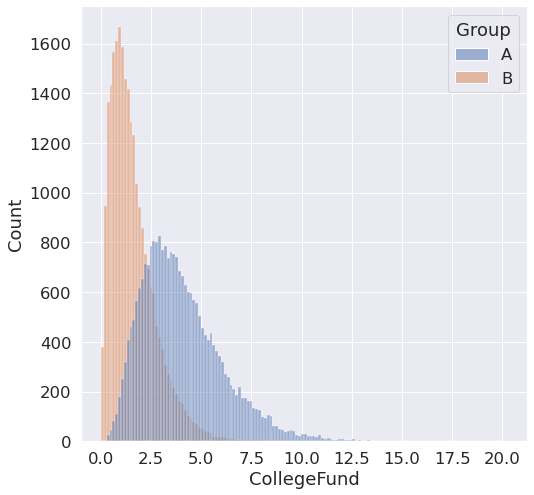

In [230]:
import math
# sns.histplot(x = sim_admission['CollegeFund'].apply(math.log1p), hue = sim_admission['Group'])
sns.histplot(x = sim_admission['CollegeFund'], hue = sim_admission['Group'])

In [231]:
sim_admission = calc_grad_prob(sim_admission)

<AxesSubplot:xlabel='BaseAbility', ylabel='p_Graduation'>

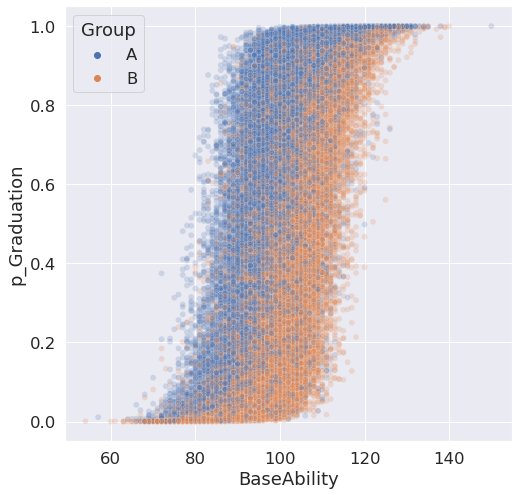

In [232]:
sns.scatterplot(data = sim_admission, x = 'BaseAbility', y = 'p_Graduation', hue= 'Group', alpha = .2)

And now, flip the (weighted) coin for each student according to their probTestingAbility of graduating to get their actual graduation outcome.

In [233]:
sim_admission = sim_graduation(sim_admission)

In [234]:
sim_admission.head()

,Group,BaseAbility,HighSchool_Indigo,CollegeFund,HSValueAdded,TestingAbility,TestScore,p_Graduation,Actual_Graduation
0,A,104,1,4.049274,21,-13,101.5,0.953017,1
1,B,92,0,2.538603,-5,-6,83.5,0.019991,0
2,A,92,1,3.287709,16,4,104.0,0.415212,1
3,A,81,1,3.360536,13,1,88.5,0.061347,0
4,B,97,0,2.046376,7,-11,89.5,0.312013,0


In [235]:
#NOTE group only kept in here for the purpose of stratified k-fold - it will not be used as a predictor
X = sim_admission.loc[:,set(MODEL_PREDICTORS + ['Group'])]
Y = sim_admission.loc[:,'Actual_Graduation']

In [236]:
from sklearn import linear_model
from sklearn import model_selection

best_acc = 0
skf = model_selection.StratifiedKFold(n_splits = 10)
# stratified k-fold will split to ensure balance on categorical groups - in our case,
# the group variable. 

if 'Group' in MODEL_PREDICTORS:
    X.loc[:,'Group'] = (X.loc[:,'Group'] == 'A').apply(int)

for idx, (train_index, test_index) in enumerate(skf.split(X, Y)):
    #split into train and test, drop group as a variable for prediction

    x_train_fold = X.iloc[train_index,:].loc[:,MODEL_PREDICTORS]
    y_train_fold = Y.iloc[train_index]
    x_test_fold = X.iloc[test_index,:].loc[:,MODEL_PREDICTORS]
    y_test_fold = Y.iloc[test_index]

    RatingPrediction = linear_model.LogisticRegression()

    #get data 
    RatingPrediction.fit(x_train_fold, y_train_fold)
    predicted_graduation = RatingPrediction.predict(x_test_fold)
    acc = np.mean(predicted_graduation == y_test_fold) # average number of correct predictions
    if acc > best_acc:
        best_acc = acc
        best_model = RatingPrediction

Now, using our best model from the stratified cross-validation, we have a model that predicts graduation correctly most of the time.

In [237]:
best_acc

0.763

In [238]:
sim_admission_pred = sim_admission.copy(deep = True)
if 'Group' in MODEL_PREDICTORS:
    sim_admission_pred.loc[:,'Group'] = (sim_admission_pred.loc[:,'Group'] == 'A').apply(int)

sim_admission.loc[:,'Predicted_p_Graduation'] = best_model.predict_proba(sim_admission_pred.loc[:,MODEL_PREDICTORS])[:,1]

In [239]:
sim_admission.head()

,Group,BaseAbility,HighSchool_Indigo,CollegeFund,HSValueAdded,TestingAbility,TestScore,p_Graduation,Actual_Graduation,Predicted_p_Graduation
0,A,104,1,4.049274,21,-13,101.5,0.953017,1,0.678525
1,B,92,0,2.538603,-5,-6,83.5,0.019991,0,0.082660
2,A,92,1,3.287709,16,4,104.0,0.415212,1,0.696597
3,A,81,1,3.360536,13,1,88.5,0.061347,0,0.405000
4,B,97,0,2.046376,7,-11,89.5,0.312013,0,0.118638


<ipython-input-240-c70eebfcf020>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','0-10%', '20-30%', '40-50%', '60-70%', '80-90%'])


[Text(-2.0, 0, ''),
 Text(0.0, 0, '0-10%'),
 Text(2.0, 0, '20-30%'),
 Text(4.0, 0, '40-50%'),
 Text(6.0, 0, '60-70%'),
 Text(8.0, 0, '80-90%'),
 Text(10.0, 0, '')]

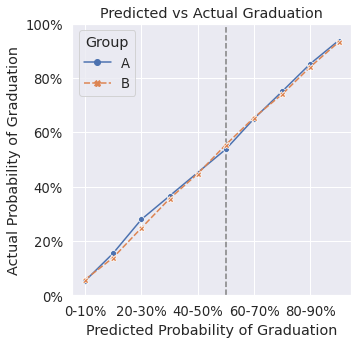

In [240]:
from matplotlib import ticker
bins, labels = pd.cut((sim_admission.loc[:,'Predicted_p_Graduation']*100).apply(int), bins = np.arange(-10,110,10), right = False).factorize(sort = True)

sim_admission.loc[:,'Predicted_p_Graduation_bin'] = bins
lineplot_admin = sim_admission.groupby(['Predicted_p_Graduation_bin', 'Group'])['Actual_Graduation'].apply(lambda x: np.mean(x) * 100).reset_index()

sns.set(rc={"figure.figsize":(5, 5)}) 
sns.set(font_scale=1.2)

ax = sns.lineplot(data = lineplot_admin,
            x = 'Predicted_p_Graduation_bin',
            y = 'Actual_Graduation',
            hue = 'Group',
            style= 'Group',
            markers = True)
plt.xlabel('Predicted Probability of Graduation')
plt.ylabel('Actual Probability of Graduation')
plt.title('Predicted vs Actual Graduation')
ax.vlines(x = 5, ymin = 0, ymax = 100, linestyle = 'dashed', color = 'grey')
ax.set(ylim = (0,100))
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
ax.set_xticklabels(['','0-10%', '20-30%', '40-50%', '60-70%', '80-90%'])

(-0.05, 0.05)

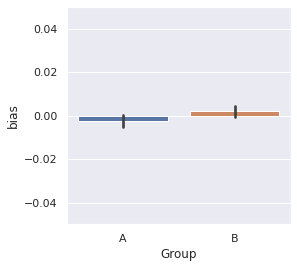

In [265]:
sim_admission.loc[:,'bias'] = sim_admission['p_Graduation'] - sim_admission['Predicted_p_Graduation']
sns.barplot(data = sim_admission, x = 'Group', y = 'bias')

plt.ylim((-.05,.05))

In [241]:
from sklearn.metrics import precision_recall_curve

precision_recall = pd.DataFrame()

simA = sim_admission[sim_admission['Group'] == 'A']
precision, recall, thresholds = precision_recall_curve(simA.loc[:,'Actual_Graduation'], simA.loc[:,'Predicted_p_Graduation'])
precision_recall = pd.concat([precision_recall, pd.DataFrame({'precision' : precision[1:],
                                            'recall'  : recall[1:],
                                            'threshold' : thresholds,
                                            'group' : 'A'})], axis = 0)

simB = sim_admission[sim_admission['Group'] == 'B']
precision, recall, thresholds = precision_recall_curve(simB.loc[:,'Actual_Graduation'], simB.loc[:,'Predicted_p_Graduation'])
precision_recall = pd.concat([precision_recall, pd.DataFrame({'precision' : precision[1:],
                                            'recall'  : recall[1:],
                                            'threshold' : thresholds,
                                            'group' : 'B'})], axis = 0)

precision_recall.loc[:, 'precision_round'] = precision_recall['precision'].apply(lambda x: round(x, ndigits = 3)*100)
precision_recall.loc[:, 'recall_round'] = precision_recall['recall'].apply(lambda x: round(x, ndigits = 3)*100)


In [242]:
precision_recall['decision_dist'] = abs(precision_recall['precision']-.8)
decision_bound = precision_recall.groupby('group')['decision_dist'].min('decision_dist')
opt_mask = (precision_recall['group'] == 'A') & (precision_recall['decision_dist'] == decision_bound['A']) |\
           (precision_recall['group'] == 'B') & (precision_recall['decision_dist'] == decision_bound['B'])
opt_p = precision_recall[opt_mask]
opt_p = opt_p.groupby('group').first() # to get the first result for dupe distances - they will be nearly identical
opt_p

,precision,recall,threshold,precision_round,recall_round,decision_dist
group,,,,,,
A,0.800013,0.797444,0.585468,80.0,79.7,0.000013
B,0.800000,0.317027,0.672475,80.0,31.7,0.000000


In [243]:
precision_recall['decision_dist'] = abs(precision_recall['recall']-.8)
decision_bound = precision_recall.groupby('group')['decision_dist'].min('decision_dist')
opt_mask = (precision_recall['group'] == 'A') & (precision_recall['decision_dist'] == decision_bound['A']) |\
           (precision_recall['group'] == 'B') & (precision_recall['decision_dist'] == decision_bound['B'])
opt_r = precision_recall[opt_mask]
opt_r = opt_r.groupby('group').first() # to get the first result for dupe distances - they will be nearly identical
opt_r

,precision,recall,threshold,precision_round,recall_round,decision_dist
group,,,,,,
A,0.799069,0.800025,0.583224,79.9,80.0,0.000025
B,0.540951,0.799976,0.273725,54.1,80.0,0.000024


In [244]:
precision_recall['decision_dist'] = abs(precision_recall['threshold']-.5)
decision_bound = precision_recall.groupby('group')['decision_dist'].min('decision_dist')
opt_mask = (precision_recall['group'] == 'A') & (precision_recall['decision_dist'] == decision_bound['A']) |\
           (precision_recall['group'] == 'B') & (precision_recall['decision_dist'] == decision_bound['B'])
opt_t = precision_recall[opt_mask]
opt_t = opt_t.groupby('group').first() # to get the first result for dupe distances - they will be nearly identical
opt_t

,precision,recall,threshold,precision_round,recall_round,decision_dist
group,,,,,,
A,0.769442,0.865949,0.500019,76.9,86.6,0.000019
B,0.701651,0.519638,0.499986,70.2,52.0,0.000014


In [245]:
diffs = opt_t.iloc[1,[0,1]] - opt_t.iloc[0,[0,1]]
m = diffs[0]/diffs[1] 
b = (opt_t.iloc[0,0] - m * opt_t.iloc[0,1])
xs = np.arange(0,1.1,.1)
ys = (m*xs + b)

<ipython-input-278-6df76d887473>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','0%','20%', '40%', '60%', '80%', '100%'])


(20.0, 100.0)

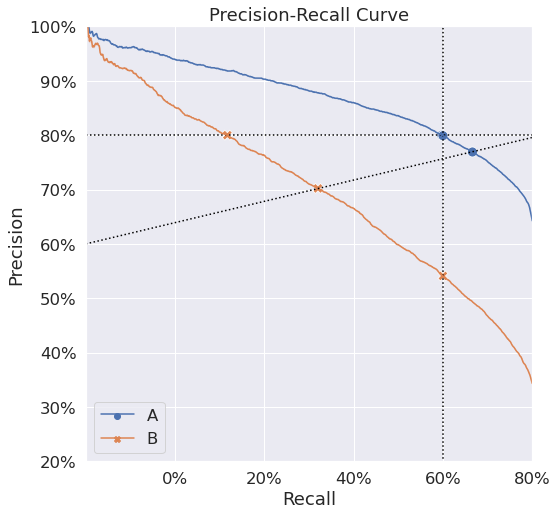

In [278]:
#create precision recall curve
fig, ax = plt.subplots()
ax = sns.lineplot(data = precision_recall, x = 'recall_round', y = 'precision_round', hue = 'group')
sns.set(rc={"figure.figsize":(8, 8)}) 
sns.set(font_scale=1.5)

# #add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

sns.scatterplot(data = opt_p, x = 'recall_round', y = 'precision_round', hue = 'group', style='group', s=100)
sns.scatterplot(data = opt_r, x = 'recall_round', y = 'precision_round', hue = 'group', style='group', s=100)
sns.scatterplot(data = opt_t, x = 'recall_round', y = 'precision_round', hue = 'group', style='group', s= 100)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=[(h1, h2) for h1, h2 in zip(handles[:2], handles[2:])],
           labels=labels[2:],
           loc = 'lower left')

ax.yaxis.set_major_formatter(ticker.PercentFormatter())
ax.set_xticklabels(['','0%','20%', '40%', '60%', '80%', '100%'])
plt.hlines(y = 80, xmin = 0, xmax = 100, linestyles= ':', color = 'black')
plt.vlines(x = 80, ymin = 0, ymax = 100, linestyles= ':', color = 'black')
plt.plot(xs*100, ys*100, linestyle= ':', color = 'black')

plt.xlim((0,100))
plt.ylim((20,100))


## "Natural" (50%) cutoff

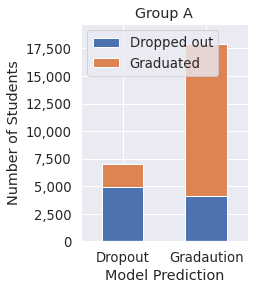

In [269]:
sns.set(rc={"figure.figsize":(3, 4)}) 
sns.set(font_scale=1.2)

hist_datA = sim_admission[(sim_admission['Group'] == 'A')]
hist_datA.loc[:,'predicted_bin'] = pd.cut(hist_datA['Predicted_p_Graduation'], bins = [0,.5,1], right = True)
hist_datA = hist_datA.groupby('predicted_bin')['Actual_Graduation'].value_counts().rename('counts').to_frame().reset_index()


hist_datB = sim_admission[(sim_admission['Group'] == 'B')]
hist_datB.loc[:,'predicted_bin'] = pd.cut(hist_datB['Predicted_p_Graduation'], bins = [0,.5,1], right = True)
hist_datB = hist_datB.groupby('predicted_bin')['Actual_Graduation'].value_counts().rename('counts').to_frame().reset_index()

max_y = max(max(hist_datA.groupby('predicted_bin')['counts'].sum()),
            max(hist_datB.groupby('predicted_bin')['counts'].sum()))


hst = hist_datA.set_index('predicted_bin').pivot(columns = 'Actual_Graduation')
hst.columns = ['Dropped out', 'Graduated']
ax = hst.plot(kind='bar', stacked = True)
plt.xlabel('Model Prediction')
plt.ylabel('Number of Students')
plt.title('Group A')
ax.set_xticklabels(['Dropout', 'Gradaution'])
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim(0,max_y + max_y*.05)
plt.xticks(rotation = 0)
plt.legend(loc = 'upper left')


(array([0, 1]), [Text(0, 0, 'Dropout'), Text(1, 0, 'Gradaution')])

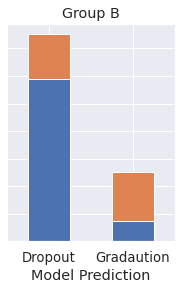

In [268]:
sns.set(rc={"figure.figsize":(3, 4)}) 
sns.set(font_scale=1.2)

hst = hist_datB.set_index('predicted_bin').pivot(columns = 'Actual_Graduation')
hst.columns = ['Dropped out', 'Graduated']
ax = hst.plot(kind='bar', stacked = True, legend=None)
plt.xlabel('Model Prediction')
plt.ylabel('')
plt.title('Group B')
plt.tick_params(labelleft=False)
ax.set_ylim(0,max_y + max_y*.05)

ax.set_xticklabels(['Dropout', 'Gradaution'])
plt.xticks(rotation = 0)

# 'School optimal' cutoff (80% precision)

/home/nick/miniconda3/envs/BPC/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/nick/miniconda3/envs/BPC/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


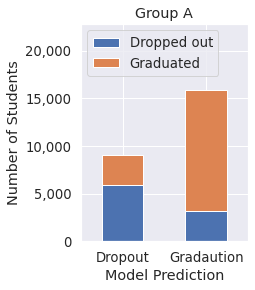

In [272]:
sns.set(rc={"figure.figsize":(3, 4)}) 
sns.set(font_scale=1.2)

hist_datA = sim_admission[(sim_admission['Group'] == 'A')]
hist_datA.loc[:,'predicted_bin'] = pd.cut(hist_datA['Predicted_p_Graduation'], bins = [0,opt_p['threshold']['A'],1], right = True)
hist_datA = hist_datA.groupby('predicted_bin')['Actual_Graduation'].value_counts().rename('counts').to_frame().reset_index()


hist_datB = sim_admission[(sim_admission['Group'] == 'B')]
hist_datB.loc[:,'predicted_bin'] = pd.cut(hist_datB['Predicted_p_Graduation'], bins = [0,opt_p['threshold']['B'],1], right = True)
hist_datB = hist_datB.groupby('predicted_bin')['Actual_Graduation'].value_counts().rename('counts').to_frame().reset_index()

max_y = max(max(hist_datA.groupby('predicted_bin')['counts'].sum()),
            max(hist_datB.groupby('predicted_bin')['counts'].sum()))


hst = hist_datA.set_index('predicted_bin').pivot(columns = 'Actual_Graduation')
hst.columns = ['Dropped out', 'Graduated']
ax = hst.plot(kind='bar', stacked = True)
plt.xlabel('Model Prediction')
plt.ylabel('Number of Students')
plt.title('Group A')
ax.set_xticklabels(['Dropout', 'Gradaution'])
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim(0,max_y + max_y*.05)
plt.xticks(rotation = 0)
plt.legend(loc = 'upper left')


(array([0, 1]), [Text(0, 0, 'Dropout'), Text(1, 0, 'Gradaution')])

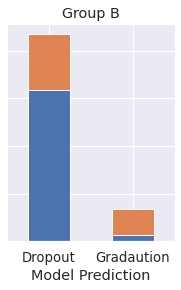

In [273]:
sns.set(rc={"figure.figsize":(3, 4)}) 
sns.set(font_scale=1.2)

hst = hist_datB.set_index('predicted_bin').pivot(columns = 'Actual_Graduation')
hst.columns = ['Dropped out', 'Graduated']
ax = hst.plot(kind='bar', stacked = True, legend=None)
plt.xlabel('Model Prediction')
plt.ylabel('')
plt.title('Group B')
plt.tick_params(labelleft=False)
ax.set_ylim(0,max_y + max_y*.05)

ax.set_xticklabels(['Dropout', 'Gradaution'])
plt.xticks(rotation = 0)

# 'Societally Optimal' cutoff (80% Recall)

/home/nick/miniconda3/envs/BPC/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/nick/miniconda3/envs/BPC/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


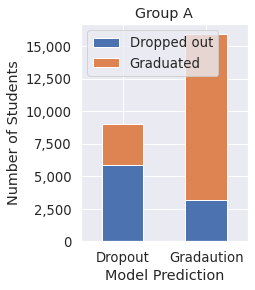

In [274]:
sns.set(rc={"figure.figsize":(3, 4)}) 
sns.set(font_scale=1.2)

hist_datA = sim_admission[(sim_admission['Group'] == 'A')]
hist_datA.loc[:,'predicted_bin'] = pd.cut(hist_datA['Predicted_p_Graduation'], bins = [0,opt_r['threshold']['A'],1], right = True)
hist_datA = hist_datA.groupby('predicted_bin')['Actual_Graduation'].value_counts().rename('counts').to_frame().reset_index()


hist_datB = sim_admission[(sim_admission['Group'] == 'B')]
hist_datB.loc[:,'predicted_bin'] = pd.cut(hist_datB['Predicted_p_Graduation'], bins = [0,opt_r['threshold']['B'],1], right = True)
hist_datB = hist_datB.groupby('predicted_bin')['Actual_Graduation'].value_counts().rename('counts').to_frame().reset_index()

max_y = max(max(hist_datA.groupby('predicted_bin')['counts'].sum()),
            max(hist_datB.groupby('predicted_bin')['counts'].sum()))


hst = hist_datA.set_index('predicted_bin').pivot(columns = 'Actual_Graduation')
hst.columns = ['Dropped out', 'Graduated']
ax = hst.plot(kind='bar', stacked = True)
plt.xlabel('Model Prediction')
plt.ylabel('Number of Students')
plt.title('Group A')
ax.set_xticklabels(['Dropout', 'Gradaution'])
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim(0,max_y + max_y*.05)
plt.xticks(rotation = 0)
plt.legend(loc = 'upper left')


(array([0, 1]), [Text(0, 0, 'Dropout'), Text(1, 0, 'Gradaution')])

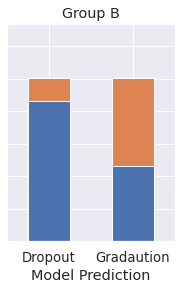

In [275]:
sns.set(rc={"figure.figsize":(3, 4)}) 
sns.set(font_scale=1.2)

hst = hist_datB.set_index('predicted_bin').pivot(columns = 'Actual_Graduation')
hst.columns = ['Dropped out', 'Graduated']
ax = hst.plot(kind='bar', stacked = True, legend=None)
plt.xlabel('Model Prediction')
plt.ylabel('')
plt.title('Group B')
plt.tick_params(labelleft=False)
ax.set_ylim(0,max_y + max_y*.05)

ax.set_xticklabels(['Dropout', 'Gradaution'])
plt.xticks(rotation = 0)

In [250]:














## Below to clean or drop depending on whether it ends up useful for explanation

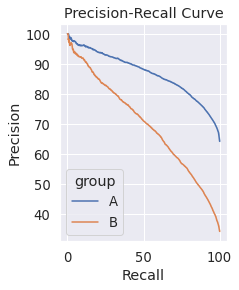

In [251]:
#create precision recall curve
fig, ax = plt.subplots()
ax = sns.lineplot(data = precision_recall, x = 'recall_round', y = 'precision_round', hue = 'group')

# #add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

# #display plot
plt.show()

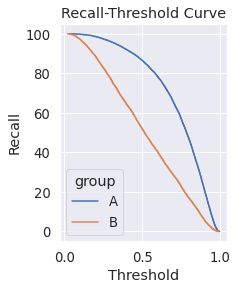

In [252]:
#create  recall curve
fig, ax = plt.subplots()
ax = sns.lineplot(data = precision_recall, x = 'threshold', y = 'recall_round', hue = 'group')

# # #add axis labels to plot
ax.set_title('Recall-Threshold Curve')
ax.set_ylabel('Recall')
ax.set_xlabel('Threshold')

# # #display plot
plt.show()

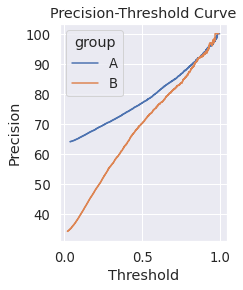

In [253]:
#create precision  curve
fig, ax = plt.subplots()
ax = sns.lineplot(data = precision_recall, x = 'threshold', y = 'precision_round', hue = 'group')

# # #add axis labels to plot
ax.set_title('Precision-Threshold Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Threshold')

# # #display plot
plt.show()

In [254]:
equal_threshold_precision = precision_recall.groupby('threshold').var().sort_values('precision').index[0]
equal_threshold_precision

0.01930009762794071

<ipython-input-255-a541d9bfc9e7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_dat['predicted_bin'] = pd.cut(hist_dat['Predicted_p_Graduation'], bins = [0, equal_threshold_precision, 1], right = True)


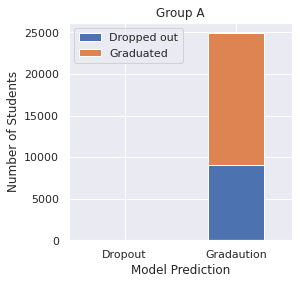

In [255]:
sns.set(rc={"figure.figsize":(4, 4)}) 

hist_dat = sim_admission[(sim_admission['Group'] == 'A')]
hist_dat['predicted_bin'] = pd.cut(hist_dat['Predicted_p_Graduation'], bins = [0, equal_threshold_precision, 1], right = True)
hist_dat = hist_dat.groupby('predicted_bin')['Actual_Graduation'].value_counts().rename('counts').to_frame().reset_index()

hst = hist_dat.set_index('predicted_bin').pivot(columns = 'Actual_Graduation')
hst.columns = ['Dropped out', 'Graduated']
ax = hst.plot(kind='bar', stacked = True)
plt.xlabel('Model Prediction')
plt.ylabel('Number of Students')
plt.title('Group A')
ax.set_xticklabels(['Dropout', 'Gradaution'])
plt.xticks(rotation = 0)
plt.legend(loc = 'upper left')


<ipython-input-256-42c163805253>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_dat['predicted_bin'] = pd.cut(hist_dat['Predicted_p_Graduation'], bins = [0, equal_threshold_precision, 1], right = True)


(array([0, 1]), [Text(0, 0, 'Dropout'), Text(1, 0, 'Gradaution')])

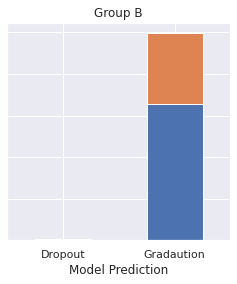

In [256]:
sns.set(rc={"figure.figsize":(4, 4)}) 

hist_dat = sim_admission[(sim_admission['Group'] == 'B')]
hist_dat['predicted_bin'] = pd.cut(hist_dat['Predicted_p_Graduation'], bins = [0, equal_threshold_precision, 1], right = True)
hist_dat = hist_dat.groupby('predicted_bin')['Actual_Graduation'].value_counts().rename('counts').to_frame().reset_index()

hst = hist_dat.set_index('predicted_bin').pivot(columns = 'Actual_Graduation')
hst.columns = ['Dropped out', 'Graduated']
ax = hst.plot(kind='bar', stacked = True, legend=None)
plt.xlabel('Model Prediction')
plt.ylabel('')
plt.title('Group B')
plt.tick_params(labelleft=False)
ax.set_xticklabels(['Dropout', 'Gradaution'])
plt.xticks(rotation = 0)

<ipython-input-257-ac832c0274d0>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','0-10%', '20-30%', '40-50%', '60-70%', '80-90%'])


[Text(-2.0, 0, ''),
 Text(0.0, 0, '0-10%'),
 Text(2.0, 0, '20-30%'),
 Text(4.0, 0, '40-50%'),
 Text(6.0, 0, '60-70%'),
 Text(8.0, 0, '80-90%'),
 Text(10.0, 0, '')]

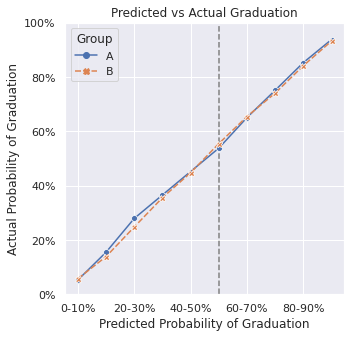

In [257]:
from matplotlib import ticker
bins, labels = pd.cut((sim_admission.loc[:,'Predicted_p_Graduation']*100).apply(int), bins = np.arange(-10,110,10), right = False).factorize(sort = True)

sim_admission.loc[:,'Predicted_p_Graduation_bin'] = bins
lineplot_admin = sim_admission.groupby(['Predicted_p_Graduation_bin', 'Group'])['Actual_Graduation'].apply(lambda x: np.mean(x) * 100).reset_index()

sns.set(rc={"figure.figsize":(5, 5)}) 

ax = sns.lineplot(data = lineplot_admin,
            x = 'Predicted_p_Graduation_bin',
            y = 'Actual_Graduation',
            hue = 'Group',
            style= 'Group',
            markers = True)
plt.xlabel('Predicted Probability of Graduation')
plt.ylabel('Actual Probability of Graduation')
plt.title('Predicted vs Actual Graduation')
ax.vlines(x = 5, ymin = 0, ymax = 100,linestyle = 'dashed', color = 'grey')
ax.set(ylim = (0,100))
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
ax.set_xticklabels(['','0-10%', '20-30%', '40-50%', '60-70%', '80-90%'])

In [258]:
thresholds = np.arange(0,1,.001)
accuracy_df = pd.DataFrame()
for threshold in thresholds:
    pred_correct = simA.loc[:,'Actual_Graduation'] ==\
        (simA.loc[:,'Predicted_p_Graduation'] > threshold).apply(int)
    acc = np.mean(pred_correct)
    accuracy_df = pd.concat([accuracy_df, pd.DataFrame({'group' : 'A',
                                         'accuracy': acc,
                                         'threshold' : threshold}, index = [threshold])], axis = 0)

    pred_correct = simB.loc[:,'Actual_Graduation'] ==\
        (simB.loc[:,'Predicted_p_Graduation'] > threshold).apply(int)
    acc = np.mean(pred_correct)
    accuracy_df = pd.concat([accuracy_df, pd.DataFrame({'group' : 'B',
                                         'accuracy': acc,
                                         'threshold' : threshold}, index = [threshold])], axis = 0)

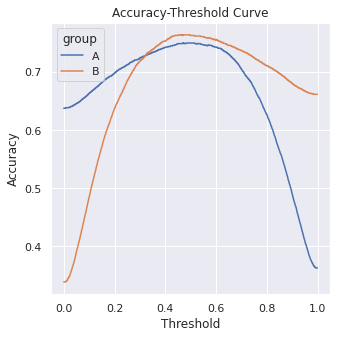

In [259]:
accuracy_df.loc[:, 'accuracy_round'] = accuracy_df['accuracy'].apply(lambda x: round(x, ndigits = 3))

#create precision recall curve
fig, ax = plt.subplots()
ax = sns.lineplot(data = accuracy_df, x = 'threshold', y = 'accuracy_round', hue = 'group')

# # #add axis labels to plot
ax.set_title('Accuracy-Threshold Curve')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Threshold')

# # #display plot
plt.show()

There _is_ a point with this model where accuracy is the same for both groups.

<ipython-input-260-1a226e11bdd2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_dat['predicted_bin'] = pd.cut(hist_dat['Predicted_p_Graduation'], bins = np.arange(0,1.5,.5), right = False)


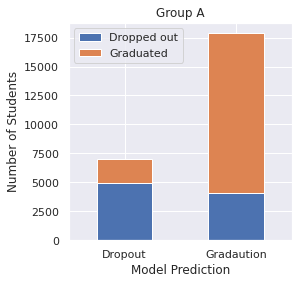

In [260]:
sns.set(rc={"figure.figsize":(4, 4)}) 

hist_dat = sim_admission[(sim_admission['Group'] == 'A')]
hist_dat['predicted_bin'] = pd.cut(hist_dat['Predicted_p_Graduation'], bins = np.arange(0,1.5,.5), right = False)
hist_dat = hist_dat.groupby('predicted_bin')['Actual_Graduation'].value_counts().rename('counts').to_frame().reset_index()

hst = hist_dat.set_index('predicted_bin').pivot(columns = 'Actual_Graduation')
hst.columns = ['Dropped out', 'Graduated']
ax = hst.plot(kind='bar', stacked = True)
plt.xlabel('Model Prediction')
plt.ylabel('Number of Students')
plt.title('Group A')
ax.set_xticklabels(['Dropout', 'Gradaution'])
plt.xticks(rotation = 0)
plt.legend(loc = 'upper left')


<ipython-input-261-a69ce8d54ba7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_dat['predicted_bin'] = pd.cut(hist_dat['Predicted_p_Graduation'], bins = np.arange(0,1.5,.5), right = False)


(array([0, 1]), [Text(0, 0, 'Dropout'), Text(1, 0, 'Gradaution')])

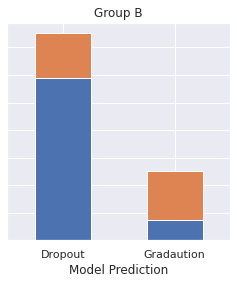

In [261]:
sns.set(rc={"figure.figsize":(4, 4)}) 

hist_dat = sim_admission[(sim_admission['Group'] == 'B')]
hist_dat['predicted_bin'] = pd.cut(hist_dat['Predicted_p_Graduation'], bins = np.arange(0,1.5,.5), right = False)
hist_dat = hist_dat.groupby('predicted_bin')['Actual_Graduation'].value_counts().rename('counts').to_frame().reset_index()

hst = hist_dat.set_index('predicted_bin').pivot(columns = 'Actual_Graduation')
hst.columns = ['Dropped out', 'Graduated']
ax = hst.plot(kind='bar', stacked = True, legend=None)
plt.xlabel('Model Prediction')
plt.ylabel('')
plt.title('Group B')
plt.tick_params(labelleft=False)
ax.set_xticklabels(['Dropout', 'Gradaution'])
plt.xticks(rotation = 0)

In [262]:
equal_threshold_acc = accuracy_df.groupby('threshold').var().sort_values('accuracy').index[0]
equal_threshold_acc


0.321

<ipython-input-263-96c3192bbda3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_dat['predicted_bin'] = pd.cut(hist_dat['Predicted_p_Graduation'], bins = [0, equal_threshold_acc, 1], right = True)


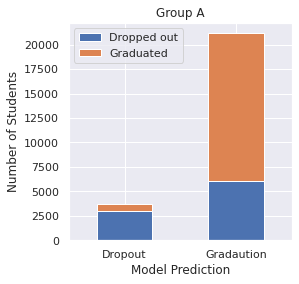

In [263]:
sns.set(rc={"figure.figsize":(4, 4)}) 

hist_dat = sim_admission[(sim_admission['Group'] == 'A')]
hist_dat['predicted_bin'] = pd.cut(hist_dat['Predicted_p_Graduation'], bins = [0, equal_threshold_acc, 1], right = True)
hist_dat = hist_dat.groupby('predicted_bin')['Actual_Graduation'].value_counts().rename('counts').to_frame().reset_index()

hst = hist_dat.set_index('predicted_bin').pivot(columns = 'Actual_Graduation')
hst.columns = ['Dropped out', 'Graduated']
ax = hst.plot(kind='bar', stacked = True)
plt.xlabel('Model Prediction')
plt.ylabel('Number of Students')
plt.title('Group A')
ax.set_xticklabels(['Dropout', 'Gradaution'])
plt.xticks(rotation = 0)
plt.legend(loc = 'upper left')


<ipython-input-264-39c9127777a0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_dat['predicted_bin'] = pd.cut(hist_dat['Predicted_p_Graduation'], bins = [0, equal_threshold_acc, 1], right = False)


(array([0, 1]), [Text(0, 0, 'Dropout'), Text(1, 0, 'Gradaution')])

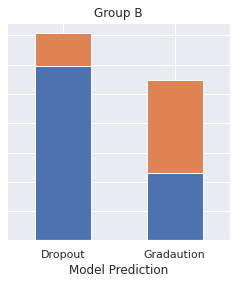

In [264]:
sns.set(rc={"figure.figsize":(4, 4)}) 

hist_dat = sim_admission[(sim_admission['Group'] == 'B')]
hist_dat['predicted_bin'] = pd.cut(hist_dat['Predicted_p_Graduation'], bins = [0, equal_threshold_acc, 1], right = False)
hist_dat = hist_dat.groupby('predicted_bin')['Actual_Graduation'].value_counts().rename('counts').to_frame().reset_index()

hst = hist_dat.set_index('predicted_bin').pivot(columns = 'Actual_Graduation')
hst.columns = ['Dropped out', 'Graduated']
ax = hst.plot(kind='bar', stacked = True, legend=None)
plt.xlabel('Model Prediction')
plt.ylabel('')
plt.title('Group B')
plt.tick_params(labelleft=False)
ax.set_xticklabels(['Dropout', 'Gradaution'])
plt.xticks(rotation = 0)